In [1]:
from rich import print
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pyarrow import parquet as pq
from tqdm import tqdm
import pandas as pd

In [3]:
from glcat_photometry_utils import mcmc_aperture_curve, plot_mcmc_results, get_percentile_ranges, plot_mcmc_walkers

In [4]:
np.random.seed(555)

In [5]:
metadata = pq.read_table('/Users/cm/github/gPhoton2/gPhoton/aspect/metadata.parquet').to_pandas()

In [6]:
ncat = pq.read_table('e23456_ncat.parquet')

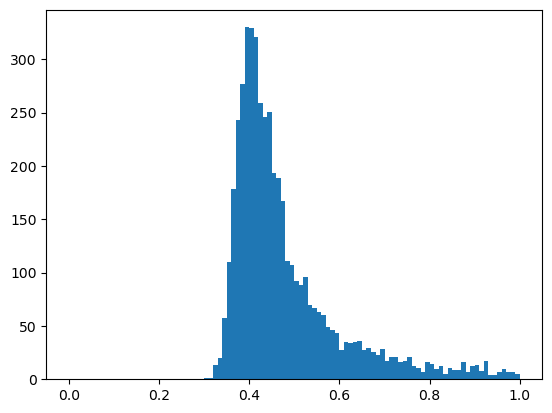

In [7]:
cps = np.array(ncat.column(f'NUV_CPS_APER4').to_pylist())
expt = np.array(ncat.column('NUV_EXPT').to_pylist())
plt.hist(cps,bins=100,range=[0,1]);

In [8]:
def run_and_plot(cat,i,
                 savefig_model=None,
                 savefig_walkers=None,
                 plot=True):
    aperture_radii = np.array([1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3])
    flux = np.array([cat.column(f'NUV_CPS_APER{a}')[i].as_py() for a, r in enumerate(aperture_radii)])
    flux_err = np.array([cat.column(f'NUV_CPS_ERR_APER{a}')[i].as_py() for a,r in enumerate(aperture_radii)])
    ix = np.where(np.isfinite(flux))
    
    flat_samples,samples = mcmc_aperture_curve(aperture_radii,flux,flux_err,
                            nsteps = 1000, # number of MCMC steps
                            burnin = 200, # number of burn-in steps
                            nwalkers = 32, # number of mc walkers
                           )
    if plot:
        plot_mcmc_results(flat_samples,aperture_radii,flux,flux_err,savefig=savefig_model)
        plot_mcmc_walkers(samples,savefig=savefig_walkers)
    return get_percentile_ranges(flat_samples), flat_samples, samples

In [29]:
fits = []
for i in tqdm(np.argsort(cps)):
    p,f,s = run_and_plot(ncat,i,
                      savefig_model=f'plots/e23456_{str(i).zfill(4)}_model.jpg',
                      savefig_walkers=f'plots/e23456_{str(i).zfill(4)}_walkers.jpg'
                      )
    fits+=[
        [i,
         p['cps'][0],p['cps'][1],p['cps'][2],
         p['bg_cps'][0],p['bg_cps'][1],p['bg_cps'][2],
         p['sigma'][0],p['sigma'][1],p['sigma'][2]]
    ]

/Users/cm/miniconda3/envs/gphoton/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3749: RuntimeWarning: invalid value encountered in add.57s/it]
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
Traceback (most recent call last):████████████████████████████▋                                              | 2880/5187 [10:34:09<1:40:56,  2.63s/it]
  File "/Users/cm/miniconda3/envs/gphoton/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/cm/github/glcat/glcat_v1_pipeline/glcat_photometry_utils.py", line 30, in log_probability
    return lp + log_likelihood(theta, r, flux, flux_err)
  File "/Users/cm/github/glcat/glcat_v1_pipeline/glcat_photometry_utils.py", line 17, in log_likelihood
    model = gaussian_flux_model(theta, r)
KeyboardInterrupt
 56%|█████████████████████████████████████████████████████████▋                                              | 2880/5187 [10:34:10<8:27:59, 13.21s

emcee: Exception while calling your likelihood function:
  params: [1.23338901e-01 1.83553172e+00 1.26619872e-03]
  args: (array([ 1.5,  2.3,  3.8,  6. ,  9. , 12.8, 17.3]), array([0.03503387, 0.0774243 , 0.15470001, 0.27570288, 0.46257568,
       0.80117508, 1.35074158]), array([0.00483243, 0.00718389, 0.01015468, 0.01355632, 0.01755952,
       0.0231092 , 0.03000595]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

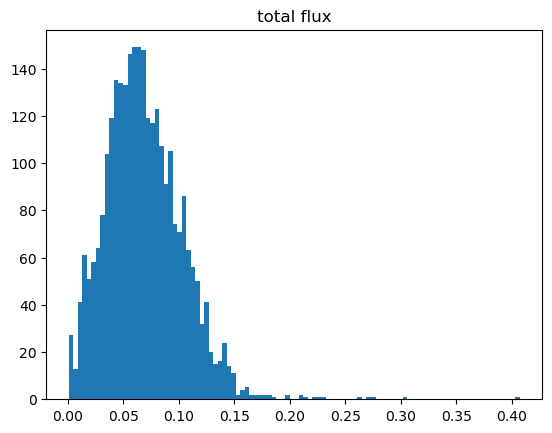

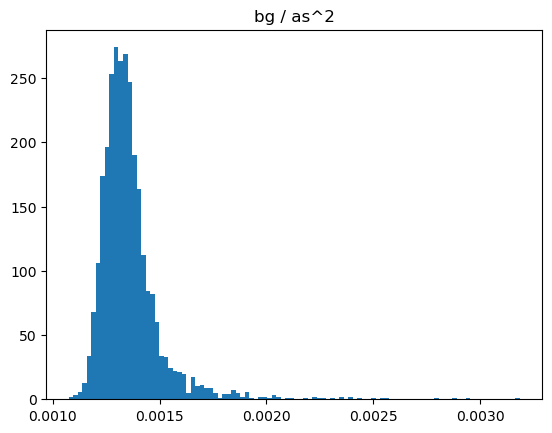

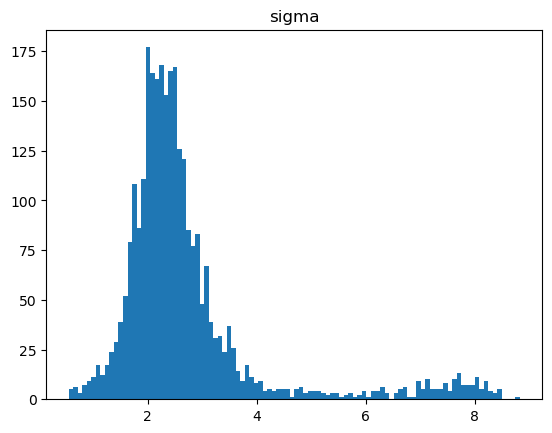

In [33]:
plt.figure()
plt.title('total flux')
plt.hist(np.array(fits)[:,1],bins=100);

plt.figure()
plt.title('bg / as^2')
plt.hist(np.array(fits)[:,4],bins=100);

plt.figure()
plt.title('sigma')
plt.hist(np.array(fits)[:,7],bins=100);

In [32]:
len(fits)

2880